[*********************100%***********************]  1 of 1 completed

Fetching data...


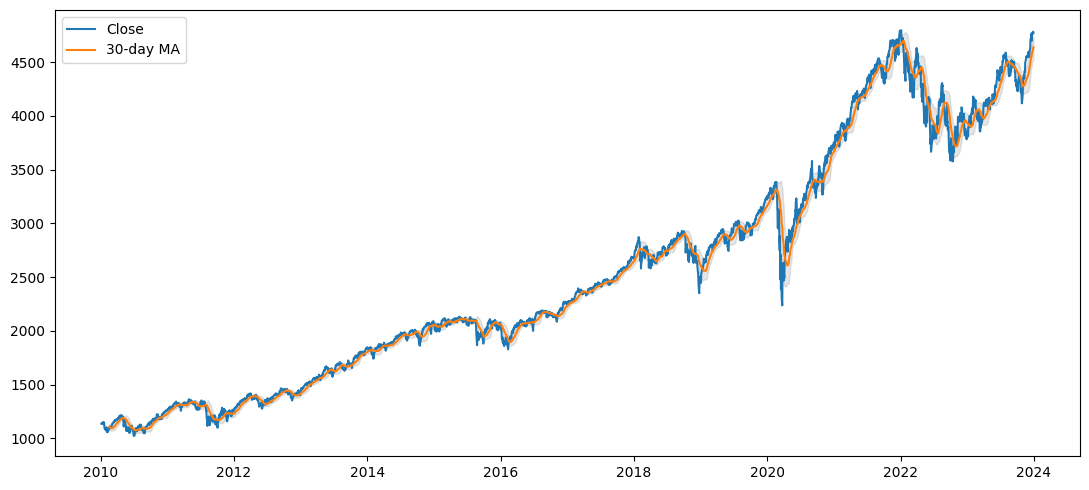

c:\Users\ksoha\OneDrive\Documents\GitHub\collegecourses\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


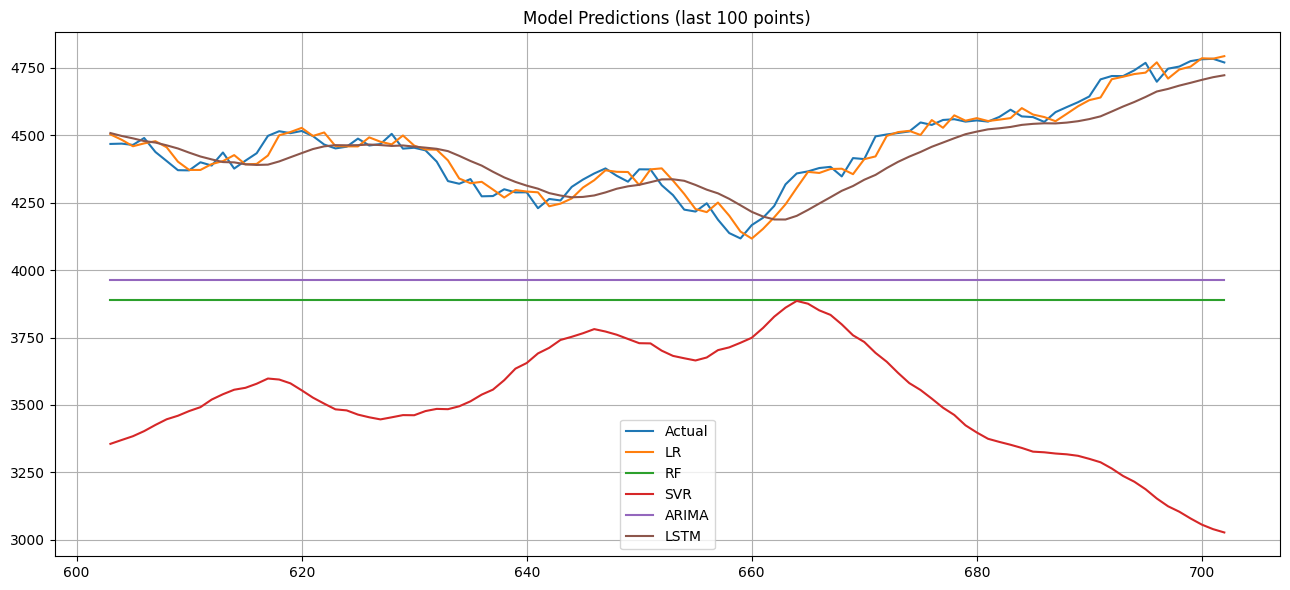


Model RMSEs:
Linear: 0.0125
RF: 0.1187
SVR: 0.2001
ARIMA: 393.5057
LSTM: 0.0208


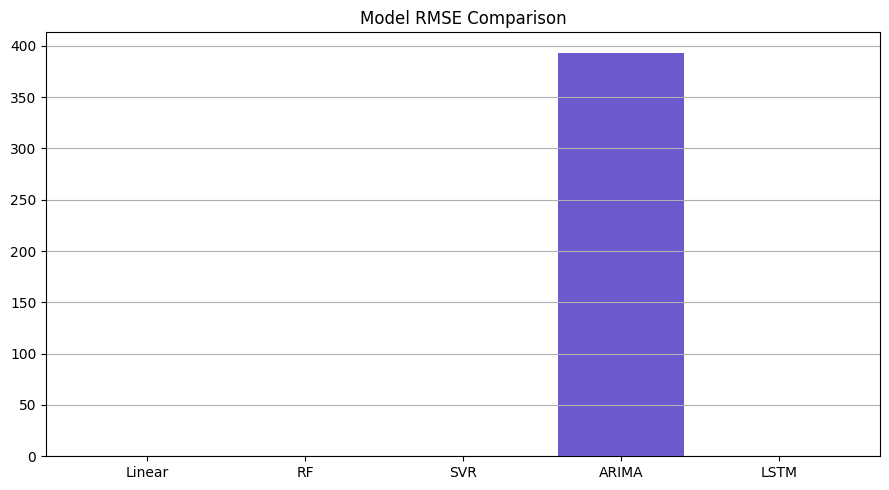

In [11]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn + keras imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA

from keras.models import Sequential
from keras.layers import LSTM, Dense

from math import sqrt

# -- Load S&P 500 data --
print("Fetching data...")
data = yf.download('^GSPC', start='2010-01-01', end='2024-01-01')
prices = data[['Close']].copy()
prices.dropna(inplace=True)
prices['daily_ret'] = prices['Close'].pct_change()
prices.dropna(inplace=True)

# -- Rolling stats, just for curiosity
prices['ma_30'] = prices['Close'].rolling(30).mean()
prices['vol'] = prices['Close'].rolling(30).std()

plt.figure(figsize=(11,5))
plt.plot(prices['Close'], label='Close')
plt.plot(prices['ma_30'], label='30-day MA')
plt.fill_between(prices.index, prices['ma_30'] - prices['vol'], prices['ma_30'] + prices['vol'], color='gray', alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

# -- Preprocessing --
scale = MinMaxScaler()
prices['scaled'] = scale.fit_transform(prices[['Close']])

def make_lags(arr, n):
    # could try using pandas shift here instead
    X, y = [], []
    for i in range(len(arr) - n):
        X.append(arr[i:i+n])
        y.append(arr[i+n])
    return np.array(X), np.array(y)

lookback = 10
X, y = make_lags(prices['scaled'].values, lookback)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

results = {}

# -- Linear Reg --
lr = LinearRegression()
lr.fit(X_train.reshape(len(X_train), -1), y_train)
lr_out = lr.predict(X_test.reshape(len(X_test), -1))
results['Linear'] = sqrt(mean_squared_error(y_test, lr_out))

# -- Random Forest --
forest = RandomForestRegressor(n_estimators=100)
forest.fit(X_train.reshape(len(X_train), -1), y_train)
rf_out = forest.predict(X_test.reshape(len(X_test), -1))
results['RF'] = sqrt(mean_squared_error(y_test, rf_out))

# -- Support Vector Regression --
svr = SVR(C=1.0, epsilon=0.01)
svr.fit(X_train.reshape(len(X_train), -1), y_train)
svr_out = svr.predict(X_test.reshape(len(X_test), -1))
results['SVR'] = sqrt(mean_squared_error(y_test, svr_out))

# -- ARIMA model --
full_series = prices['Close'].values
train_arima = full_series[:-len(y_test)]
test_arima = full_series[-len(y_test):]

model_arima = ARIMA(train_arima, order=(5,1,0))
arima_fit = model_arima.fit()
arima_preds = arima_fit.forecast(steps=len(test_arima))
results['ARIMA'] = sqrt(mean_squared_error(test_arima, arima_preds))

# -- LSTM -- (not confident this is optimized)
X_lstm_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_lstm_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

lstm = Sequential()
lstm.add(LSTM(50, input_shape=(lookback, 1)))
lstm.add(Dense(1))
lstm.compile(loss='mse', optimizer='adam')
lstm.fit(X_lstm_train, y_train, epochs=8, batch_size=32, verbose=0)

lstm_out = lstm.predict(X_lstm_test).flatten()
results['LSTM'] = sqrt(mean_squared_error(y_test, lstm_out))

# -- Plotting last 100 predictions --
actuals = scale.inverse_transform(y_test.reshape(-1, 1)).flatten()
df_preds = pd.DataFrame({
    'Actual': actuals,
    'LR': scale.inverse_transform(lr_out.reshape(-1,1)).flatten(),
    'RF': scale.inverse_transform(rf_out.reshape(-1,1)).flatten(),
    'SVR': scale.inverse_transform(svr_out.reshape(-1,1)).flatten(),
    'ARIMA': arima_preds,
    'LSTM': scale.inverse_transform(lstm_out.reshape(-1,1)).flatten()
})

plt.figure(figsize=(13,6))
plt.plot(df_preds['Actual'][-100:], label='Actual')
for col in ['LR', 'RF', 'SVR', 'ARIMA', 'LSTM']:
    plt.plot(df_preds[col][-100:], label=col)
plt.title('Model Predictions (last 100 points)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# -- RMSE summary --
print("\nModel RMSEs:")
for model in results:
    print(f"{model}: {results[model]:.4f}")

plt.figure(figsize=(9,5))
plt.bar(results.keys(), results.values(), color='slateblue')
plt.title("Model RMSE Comparison")
plt.tight_layout()
plt.grid(axis='y')
plt.show()